In [1]:
# ============================================
# XGBOOST - PHISHING URL DETECTION
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
import pickle
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("XGBOOST - PHISHING URL DETECTION")
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

XGBOOST - PHISHING URL DETECTION
Started at: 2025-11-02 01:19:06


In [2]:
# ============================================
# STEP 1: LOAD PROCESSED DATA
# ============================================

print("LOADING DATA")

# Define paths
TRAIN_PATH = '../../../data/processed/url-detection/phishing_features_train.csv'
TEST_PATH = '../../../data/processed/url-detection/phishing_features_test.csv'

# Load data
print("\nLoading training data...")
train_df = pd.read_csv(TRAIN_PATH)
print(f"Train data loaded: {train_df.shape[0]:,} rows, {train_df.shape[1]} columns")

print("\nLoading test data...")
test_df = pd.read_csv(TEST_PATH)
print(f"Test data loaded: {test_df.shape[0]:,} rows, {test_df.shape[1]} columns")

# Prepare data
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

# Handle missing values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Encode labels as binary (XGBoost needs 0/1, not strings)
# WHAT: Convert 'benign'/'phish' to 0/1
# WHY: XGBoost requires numerical labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # benign=0, phish=1
y_test_encoded = le.transform(y_test)

print(f"\nData prepared:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train_encoded.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test_encoded.shape}")
print(f"\nLabel encoding: benign=0, phish=1")

# Class distribution
print(f"\nClass distribution:")
unique, counts = np.unique(y_train_encoded, return_counts=True)
for label, count in zip(unique, counts):
    label_name = 'benign' if label == 0 else 'phish'
    print(f"   {label_name} ({label}): {count:,} ({count/len(y_train_encoded)*100:.1f}%)")

LOADING DATA

Loading training data...
Train data loaded: 371,941 rows, 521 columns

Loading test data...
Test data loaded: 36,787 rows, 521 columns

Data prepared:
   X_train: (371941, 520)
   y_train: (371941,)
   X_test: (36787, 520)
   y_test: (36787,)

Label encoding: benign=0, phish=1

Class distribution:
   benign (0): 253,189 (68.1%)
   phish (1): 118,752 (31.9%)


In [4]:
# ============================================
# STEP 3: BASELINE XGBOOST (NO TUNING)
# ============================================

print("BASELINE XGBOOST (DEFAULT PARAMETERS)")

# Calculate scale_pos_weight for imbalanced data
# WHAT: Ratio of negative to positive samples
# WHY: Tells XGBoost how to balance the classes
# FORMULA: scale_pos_weight = count(negative) / count(positive)
n_benign = (y_train_encoded == 0).sum()
n_phish = (y_train_encoded == 1).sum()
scale_pos_weight = n_benign / n_phish

print(f"\nClass imbalance handling:")
print(f"   Benign samples: {n_benign:,}")
print(f"   Phishing samples: {n_phish:,}")
print(f"   Scale_pos_weight: {scale_pos_weight:.2f}")
print(f"   → XGBoost will treat phishing {scale_pos_weight:.0f}x more important")

# Train baseline XGBoost
print("\nTraining baseline XGBoost...")
baseline_start = datetime.now()

baseline_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

baseline_model.fit(X_train, y_train_encoded)

baseline_end = datetime.now()
baseline_time = (baseline_end - baseline_start).total_seconds()

print(f"Baseline training complete!")
print(f"Training time: {baseline_time:.2f} seconds")

# Evaluate baseline
baseline_pred = baseline_model.predict(X_test)
baseline_pred_proba = baseline_model.predict_proba(X_test)[:, 1]
baseline_accuracy = accuracy_score(y_test_encoded, baseline_pred)
baseline_precision = precision_score(y_test_encoded, baseline_pred)
baseline_recall = recall_score(y_test_encoded, baseline_pred)
baseline_f1 = f1_score(y_test_encoded, baseline_pred)

baseline_roc_auc = roc_auc_score(y_test_encoded, baseline_pred_proba)

print("\nBaseline XGBoost Results (No Tuning):")
print(f"   Accuracy:  {baseline_accuracy*100:.2f}%")
print(f"   Precision: {baseline_precision*100:.2f}%")
print(f"   Recall:    {baseline_recall*100:.2f}%")
print(f"   F1-Score:  {baseline_f1*100:.2f}%")


BASELINE XGBOOST (DEFAULT PARAMETERS)

Class imbalance handling:
   Benign samples: 253,189
   Phishing samples: 118,752
   Scale_pos_weight: 2.13
   → XGBoost will treat phishing 2x more important

Training baseline XGBoost...
Baseline training complete!
Training time: 17.01 seconds

Baseline XGBoost Results (No Tuning):
   Accuracy:  95.20%
   Precision: 86.25%
   Recall:    87.83%
   F1-Score:  87.03%


In [ ]:
# ============================================
# STEP 3.5: MANUAL HYPERPARAMETER TUNING (ACCURACY OPTIMIZATION)
# ============================================

print("\n" + "="*60)
print("MANUAL HYPERPARAMETER TUNING (ACCURACY OPTIMIZATION)")
print("="*60)

print("""
Goal: Maximize Accuracy (Overall Correct Predictions)

Current Baseline Performance:
   - Accuracy: {:.2%}
   - Precision: {:.2%}
   - Recall: {:.2%}
   - F1-Score: {:.2%}

Manual Tuning Strategy:
   We'll tune 4 key parameters sequentially, each with 5-fold CV:
   
   1. scale_pos_weight  → Balance classes for accuracy
   2. max_depth         → Model complexity  
   3. min_child_weight  → Regularization
   4. learning_rate + n_estimators → Final optimization

Optimization Metric: Accuracy (correct predictions / total predictions)
""".format(baseline_accuracy, baseline_precision, baseline_recall, baseline_f1))

import time

# Track tuning start time
tuning_start = datetime.now()

# ============================================
# STEP 3.5.1: TUNE SCALE_POS_WEIGHT
# ============================================

print("\n" + "="*60)
print("STEP 3.5.1: Tuning scale_pos_weight")
print("="*60)
print(f"Current baseline value: {scale_pos_weight:.2f}")
print("Testing values: [1.5, 2, 2.13, 2.5, 3, 3.5]")
print("(Finding optimal balance for maximum accuracy)\n")

best_accuracy = 0
best_weight = scale_pos_weight
weight_results = []

step_start = time.time()

for weight in [1.5, 2, 2.13, 2.5, 3, 3.5]:
    print(f"  Testing scale_pos_weight={weight}...", end=" ", flush=True)
    
    model = xgb.XGBClassifier(
        scale_pos_weight=weight,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        verbosity=0
    )
    
    # 5-fold CV on training data
    cv_scores = cross_val_score(
        model, X_train, y_train_encoded,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    mean_accuracy = cv_scores.mean()
    std_accuracy = cv_scores.std()
    
    weight_results.append({
        'weight': weight,
        'accuracy_mean': mean_accuracy,
        'accuracy_std': std_accuracy
    })
    
    print(f"Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_weight = weight

step_time = time.time() - step_start

print(f"\nBest scale_pos_weight: {best_weight}")
print(f"   CV Accuracy: {best_accuracy:.4f}")
print(f"   Improvement: {(best_accuracy - baseline_accuracy)*100:+.2f}% vs baseline")
print(f"   Time taken: {step_time:.1f} seconds")

# ============================================
# STEP 3.5.2: TUNE MAX_DEPTH
# ============================================

print("\n" + "="*60)
print("STEP 3.5.2: Tuning max_depth")
print("="*60)
print(f"Using scale_pos_weight={best_weight}")
print("Testing values: [4, 5, 6, 7, 8, 10]\n")

best_accuracy_depth = 0
best_depth = 6
depth_results = []

step_start = time.time()

for depth in [4, 5, 6, 7, 8, 10]:
    print(f"  Testing max_depth={depth}...", end=" ", flush=True)
    
    model = xgb.XGBClassifier(
        scale_pos_weight=best_weight,
        max_depth=depth,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        verbosity=0
    )
    
    cv_scores = cross_val_score(
        model, X_train, y_train_encoded,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    mean_accuracy = cv_scores.mean()
    std_accuracy = cv_scores.std()
    
    depth_results.append({
        'depth': depth,
        'accuracy_mean': mean_accuracy,
        'accuracy_std': std_accuracy
    })
    
    print(f"Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    
    if mean_accuracy > best_accuracy_depth:
        best_accuracy_depth = mean_accuracy
        best_depth = depth

step_time = time.time() - step_start

print(f"\nBest max_depth: {best_depth}")
print(f"   CV Accuracy: {best_accuracy_depth:.4f}")
print(f"   Improvement: {(best_accuracy_depth - best_accuracy)*100:+.2f}% vs previous step")
print(f"   Time taken: {step_time:.1f} seconds")

# ============================================
# STEP 3.5.3: TUNE MIN_CHILD_WEIGHT
# ============================================

print("\n" + "="*60)
print("STEP 3.5.3: Tuning min_child_weight")
print("="*60)
print(f"Using scale_pos_weight={best_weight}, max_depth={best_depth}")
print("Testing values: [1, 2, 3, 5, 7]\n")

best_accuracy_mcw = 0
best_mcw = 1
mcw_results = []

step_start = time.time()

for mcw in [1, 2, 3, 5, 7]:
    print(f"  Testing min_child_weight={mcw}...", end=" ", flush=True)
    
    model = xgb.XGBClassifier(
        scale_pos_weight=best_weight,
        max_depth=best_depth,
        min_child_weight=mcw,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        verbosity=0
    )
    
    cv_scores = cross_val_score(
        model, X_train, y_train_encoded,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    mean_accuracy = cv_scores.mean()
    std_accuracy = cv_scores.std()
    
    mcw_results.append({
        'min_child_weight': mcw,
        'accuracy_mean': mean_accuracy,
        'accuracy_std': std_accuracy
    })
    
    print(f"Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    
    if mean_accuracy > best_accuracy_mcw:
        best_accuracy_mcw = mean_accuracy
        best_mcw = mcw

step_time = time.time() - step_start

print(f"\nBest min_child_weight: {best_mcw}")
print(f"   CV Accuracy: {best_accuracy_mcw:.4f}")
print(f"   Improvement: {(best_accuracy_mcw - best_accuracy_depth)*100:+.2f}% vs previous step")
print(f"   Time taken: {step_time:.1f} seconds")

# ============================================
# STEP 3.5.4: TUNE LEARNING_RATE + N_ESTIMATORS
# ============================================

print("\n" + "="*60)
print("STEP 3.5.4: Tuning learning_rate + n_estimators")
print("="*60)
print(f"Using scale_pos_weight={best_weight}, max_depth={best_depth}, min_child_weight={best_mcw}\n")

best_accuracy_lr = 0
best_lr_config = {'learning_rate': 0.1, 'n_estimators': 100}
lr_results = []

step_start = time.time()

configs = [
    {'learning_rate': 0.3, 'n_estimators': 100},
    {'learning_rate': 0.1, 'n_estimators': 100},
    {'learning_rate': 0.05, 'n_estimators': 200},
    {'learning_rate': 0.03, 'n_estimators': 300},
]

for config in configs:
    lr = config['learning_rate']
    n_est = config['n_estimators']
    print(f"  Testing lr={lr:.2f}, n_estimators={n_est}...", end=" ", flush=True)
    
    model = xgb.XGBClassifier(
        scale_pos_weight=best_weight,
        max_depth=best_depth,
        min_child_weight=best_mcw,
        learning_rate=lr,
        n_estimators=n_est,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        verbosity=0
    )
    
    cv_scores = cross_val_score(
        model, X_train, y_train_encoded,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    mean_accuracy = cv_scores.mean()
    std_accuracy = cv_scores.std()
    
    lr_results.append({
        'learning_rate': lr,
        'n_estimators': n_est,
        'accuracy_mean': mean_accuracy,
        'accuracy_std': std_accuracy
    })
    
    print(f"Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    
    if mean_accuracy > best_accuracy_lr:
        best_accuracy_lr = mean_accuracy
        best_lr_config = config

step_time = time.time() - step_start

print(f"\nBest config: lr={best_lr_config['learning_rate']}, n_estimators={best_lr_config['n_estimators']}")
print(f"   CV Accuracy: {best_accuracy_lr:.4f}")
print(f"   Improvement: {(best_accuracy_lr - best_accuracy_mcw)*100:+.2f}% vs previous step")
print(f"   Time taken: {step_time:.1f} seconds")

# ============================================
# FINAL SUMMARY
# ============================================

tuning_end = datetime.now()
total_tuning_time = (tuning_end - tuning_start).total_seconds()

print("\n" + "="*60)
print("MANUAL TUNING COMPLETE - SUMMARY")
print("="*60)

print("\nBEST HYPERPARAMETERS FOUND:")
print(f"   scale_pos_weight:  {best_weight}")
print(f"   max_depth:         {best_depth}")
print(f"   min_child_weight:  {best_mcw}")
print(f"   learning_rate:     {best_lr_config['learning_rate']}")
print(f"   n_estimators:      {best_lr_config['n_estimators']}")

print("\nACCURACY PROGRESSION:")
print(f"   Baseline (default):              {baseline_accuracy:.2%}")
print(f"   After scale_pos_weight tuning:   {best_accuracy:.2%} ({(best_accuracy-baseline_accuracy)*100:+.2f}%)")
print(f"   After max_depth tuning:          {best_accuracy_depth:.2%} ({(best_accuracy_depth-baseline_accuracy)*100:+.2f}%)")
print(f"   After min_child_weight tuning:   {best_accuracy_mcw:.2%} ({(best_accuracy_mcw-baseline_accuracy)*100:+.2f}%)")
print(f"   After learning_rate tuning:      {best_accuracy_lr:.2%} ({(best_accuracy_lr-baseline_accuracy)*100:+.2f}%)")

print(f"\nTOTAL IMPROVEMENT: {(best_accuracy_lr-baseline_accuracy)*100:+.2f}%")
print(f"   From {baseline_accuracy:.2%} → {best_accuracy_lr:.2%}")

print(f"\nTOTAL TUNING TIME: {total_tuning_time:.2f} seconds ({total_tuning_time/60:.2f} minutes)")

print("\nNOTE: These are CV scores on training data.")
print("   Final test set evaluation will come next")

# Train the final tuned model
print("\n" + "="*60)
print("TRAINING FINAL TUNED MODEL")
print("="*60)

final_train_start = datetime.now()

tuned_model = xgb.XGBClassifier(
    scale_pos_weight=best_weight,
    max_depth=best_depth,
    min_child_weight=best_mcw,
    learning_rate=best_lr_config['learning_rate'],
    n_estimators=best_lr_config['n_estimators'],
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    verbosity=1
)

print("\nTraining on full training set...")
tuned_model.fit(X_train, y_train_encoded)

final_train_end = datetime.now()
final_train_time = (final_train_end - final_train_start).total_seconds()

print(f"\nFinal model trained!")
print(f"   Training time: {final_train_time:.2f} seconds")

In [5]:
# ============================================
# STEP 3.6: FINAL EVALUATION - TUNED MODEL ON TEST SET
# ============================================

print("\n" + "="*60)
print("FINAL EVALUATION - TUNED MODEL ON TEST SET (ACCURACY-OPTIMIZED)")
print("="*60)

# Load the saved model instead of using the trained model directly
model_path = '../../../models/url-detection/xgboost.pkl'

if os.path.exists(model_path):
    print(f"\nLoading saved model from {model_path}...")
    with open(model_path, 'rb') as f:
        tuned_model_loaded = pickle.load(f)
    print("Model loaded successfully")
    
    # Get model size
    model_size = os.path.getsize(model_path) / (1024 * 1024)
    print(f"Model file size: {model_size:.2f} MB")
else:
    print(f"\nSaved model not found at {model_path}")
    print("Using the freshly trained model instead...")
    tuned_model_loaded = tuned_model

# Make predictions on test set using loaded model
print("\nMaking predictions on test set...")
tuned_pred = tuned_model_loaded.predict(X_test)
tuned_pred_proba = tuned_model_loaded.predict_proba(X_test)[:, 1]

# Calculate metrics
tuned_accuracy = accuracy_score(y_test_encoded, tuned_pred)
tuned_precision = precision_score(y_test_encoded, tuned_pred)
tuned_recall = recall_score(y_test_encoded, tuned_pred)
tuned_f1 = f1_score(y_test_encoded, tuned_pred)
tuned_auc = roc_auc_score(y_test_encoded, tuned_pred_proba)

# Performance comparison
print("\nTest Set Results:")
print(f"\n{'Metric':<12} {'Baseline':<12} {'Tuned':<12} {'Change':<12}")
print("-" * 48)
print(f"{'Accuracy':<12} {baseline_accuracy*100:>10.2f}%  {tuned_accuracy*100:>10.2f}%  {(tuned_accuracy-baseline_accuracy)*100:>+10.2f}%")
print(f"{'Precision':<12} {baseline_precision*100:>10.2f}%  {tuned_precision*100:>10.2f}%  {(tuned_precision-baseline_precision)*100:>+10.2f}%")
print(f"{'Recall':<12} {baseline_recall*100:>10.2f}%  {tuned_recall*100:>10.2f}%  {(tuned_recall-baseline_recall)*100:>+10.2f}%")
print(f"{'F1-Score':<12} {baseline_f1*100:>10.2f}%  {tuned_f1*100:>10.2f}%  {(tuned_f1-baseline_f1)*100:>+10.2f}%")
print(f"{'ROC-AUC':<12} {baseline_roc_auc:>11.4f}  {tuned_auc:>11.4f}  {tuned_auc-baseline_roc_auc:>+11.4f}")

# Confusion matrices
cm_baseline = confusion_matrix(y_test_encoded, baseline_pred)
cm_tuned = confusion_matrix(y_test_encoded, tuned_pred)

baseline_tn, baseline_fp, baseline_fn, baseline_tp = cm_baseline.ravel()
tuned_tn, tuned_fp, tuned_fn, tuned_tp = cm_tuned.ravel()

print(f"\nError Analysis:")
print(f"\n{'Error Type':<30} {'Baseline':<12} {'Tuned':<12} {'Change':<12}")
print("-" * 66)
print(f"{'False Negatives (Missed Phish)':<30} {baseline_fn:>11,}  {tuned_fn:>11,}  {baseline_fn-tuned_fn:>+11,}")
print(f"{'False Positives (False Alarm)':<30} {baseline_fp:>11,}  {tuned_fp:>11,}  {baseline_fp-tuned_fp:>+11,}")
print(f"{'True Negatives (Correct Benign)':<30} {baseline_tn:>11,}  {tuned_tn:>11,}  {tuned_tn-baseline_tn:>+11,}")
print(f"{'True Positives (Correct Phish)':<30} {baseline_tp:>11,}  {tuned_tp:>11,}  {tuned_tp-baseline_tp:>+11,}")

# Summary
print(f"\nSummary:")
accuracy_improvement = (tuned_accuracy - baseline_accuracy) * 100
f1_improvement = (tuned_f1 - baseline_f1) * 100
recall_improvement = (tuned_recall - baseline_recall) * 100
precision_improvement = (tuned_precision - baseline_precision) * 100

print(f"   Accuracy:  {baseline_accuracy:.2%} → {tuned_accuracy:.2%} ({accuracy_improvement:+.2f}%)")
print(f"   F1-Score:  {baseline_f1:.2%} → {tuned_f1:.2%} ({f1_improvement:+.2f}%)")
print(f"   Precision: {baseline_precision:.2%} → {tuned_precision:.2%} ({precision_improvement:+.2f}%)")
print(f"   Recall:    {baseline_recall:.2%} → {tuned_recall:.2%} ({recall_improvement:+.2f}%)")

if accuracy_improvement > 0:
    print(f"\n   ✓ Accuracy improved by {accuracy_improvement:.2f} percentage points!")
    total_errors_baseline = baseline_fp + baseline_fn
    total_errors_tuned = tuned_fp + tuned_fn
    error_reduction = total_errors_baseline - total_errors_tuned
    print(f"   ✓ Total errors reduced: {total_errors_baseline:,} → {total_errors_tuned:,} ({error_reduction:+,})")
else:
    print(f"\n   Accuracy changed by {accuracy_improvement:.2f} percentage points")

# Breakdown of changes
print(f"\nDetailed Changes:")
additional_caught = tuned_tp - baseline_tp
additional_missed = tuned_fn - baseline_fn
additional_fp = tuned_fp - baseline_fp
additional_tn = tuned_tn - baseline_tn

if additional_caught > 0:
    print(f"   ✓ Caught {additional_caught:+,} more phishing URLs")
elif additional_caught < 0:
    print(f"   Caught {additional_caught:,} fewer phishing URLs")

if additional_missed < 0:
    print(f"   ✓ Missed {abs(additional_missed):,} fewer phishing URLs")
elif additional_missed > 0:
    print(f"   Missed {additional_missed:+,} more phishing URLs")

if additional_fp < 0:
    print(f"   ✓ {abs(additional_fp):,} fewer false alarms")
elif additional_fp > 0:
    print(f"   {additional_fp:+,} more false alarms")

print(f"\nBest Parameters: spw={best_weight}, depth={best_depth}, mcw={best_mcw}, lr={best_lr_config['learning_rate']}, n={best_lr_config['n_estimators']}")

print("\nEvaluation complete!")
print(f"✓ Using {'saved' if os.path.exists(model_path) else 'trained'} model for evaluation")


FINAL EVALUATION - TUNED MODEL ON TEST SET (ACCURACY-OPTIMIZED)

Loading saved model from ../../../models/url-detection/xgboost.pkl...
Model loaded successfully
Model file size: 0.84 MB

Making predictions on test set...

Test Set Results:

Metric       Baseline     Tuned        Change      
------------------------------------------------
Accuracy          95.20%       96.05%       +0.84%
Precision         86.25%       91.36%       +5.12%
Recall            87.83%       86.62%       -1.22%
F1-Score          87.03%       88.92%       +1.89%
ROC-AUC           0.9840       0.9870      +0.0029

Error Analysis:

Error Type                     Baseline     Tuned        Change      
------------------------------------------------------------------
False Negatives (Missed Phish)         820          902          -82
False Positives (False Alarm)          944          552         +392
True Negatives (Correct Benign)      29,104       29,496         +392
True Positives (Correct Phish)       5,

NameError: name 'best_weight' is not defined

In [ ]:
# Adjust prediction threshold instead of retraining
for threshold in [0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70]:
    pred_adjusted = (tuned_pred_proba >= threshold).astype(int)
    recall = recall_score(y_test_encoded, pred_adjusted)
    precision = precision_score(y_test_encoded, pred_adjusted)
    accuracy = accuracy_score(y_test_encoded, pred_adjusted)
    f1 = f1_score(y_test_encoded, pred_adjusted)
    
    print(f"Threshold {threshold}: Recall={recall:.2%}, Precision={precision:.2%}, F1={f1:.2%}, Accuracy={accuracy:.2%}") 

In [6]:
best_threshold = 0.4
final_pred = (tuned_pred_proba >= best_threshold).astype(int)
final_accuracy = accuracy_score(y_test_encoded, final_pred)
final_precision = precision_score(y_test_encoded, final_pred)
final_recall = recall_score(y_test_encoded, final_pred)
final_f1 = f1_score(y_test_encoded, final_pred)

print(f"Final Model: Threshold={best_threshold}, Accuracy={final_accuracy:.2%}, Precision={final_precision:.2%}, Recall={final_recall:.2%}, F1={final_f1:.2%}")

#save optimized threshold
optimal_config = {
    'threshold': best_threshold,
    'accuracy': final_accuracy,
    'precision': final_precision,
    'recall': final_recall,
    'f1': final_f1
}
import json
with open('xgboost_optimal_threshold.json', 'w') as f:
    json.dump(optimal_config, f)

print(f"\nOptimal threshold saved to xgboost_optimal_threshold.json")

Final Model: Threshold=0.4, Accuracy=95.85%, Precision=88.47%, Recall=88.94%, F1=88.71%

Optimal threshold saved to xgboost_optimal_threshold.json


CONFUSION MATRIX

Confusion Matrix:
[[29267   781]
 [  745  5994]]

Interpretation:
  True Negatives (TN):  29,267 - Correctly identified benign
  False Positives (FP): 781 - Benign wrongly flagged as phishing
  False Negatives (FN): 745 - Phishing missed!
  True Positives (TP):  5,994 - Correctly identified phishing

Comparison with Random Forest:
  False Negatives: RF: 1,089 → XGB: 745 (-344)
  False Positives: RF: 801 → XGB: 781 (-20)


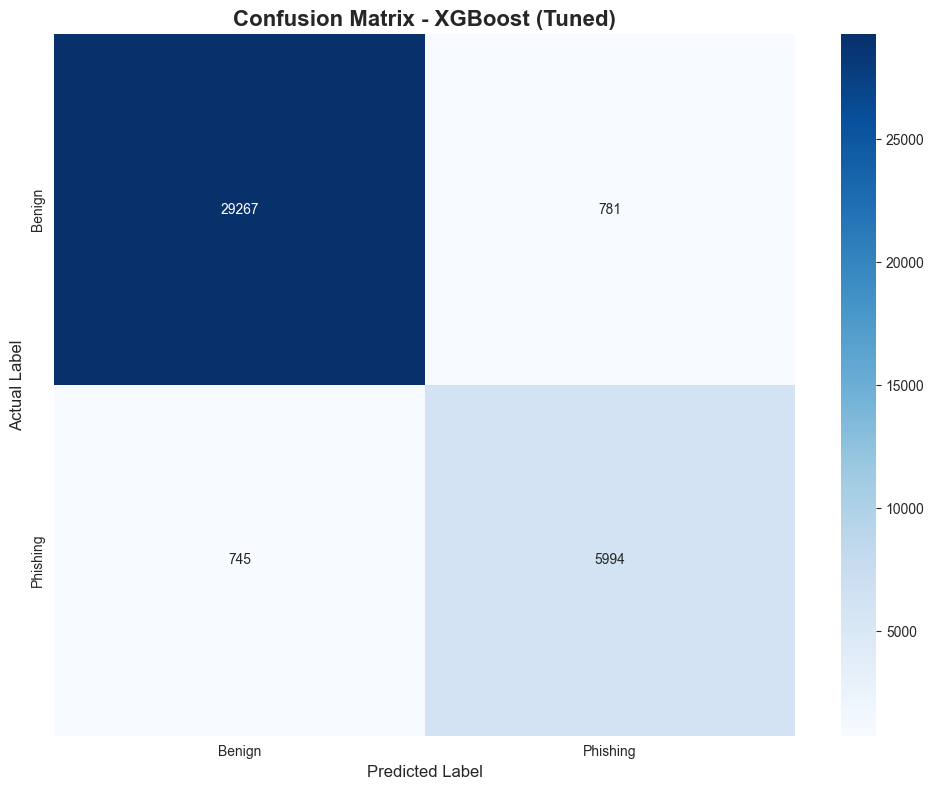


Error Analysis:
  False Positive Rate: 2.60% (benign marked as phishing)
  False Negative Rate: 11.06% (phishing that slipped through)

  Comparison:
  FPR: RF: 2.67% → XGB: 2.60% (-0.07%)
  FNR: RF: 16.16% → XGB: 11.06% (-5.10%)


In [7]:
# ============================================
# STEP 4: CONFUSION MATRIX
# ============================================

print("CONFUSION MATRIX")

# Calculate confusion matrix
cm = confusion_matrix(y_test_encoded, final_pred)

print("\nConfusion Matrix:")
print(cm)
print("\nInterpretation:")
print(f"  True Negatives (TN):  {cm[0,0]:,} - Correctly identified benign")
print(f"  False Positives (FP): {cm[0,1]:,} - Benign wrongly flagged as phishing")
print(f"  False Negatives (FN): {cm[1,0]:,} - Phishing missed!")
print(f"  True Positives (TP):  {cm[1,1]:,} - Correctly identified phishing")

# Compare with Random Forest
print("\nComparison with Random Forest:")
print(f"  False Negatives: RF: 1,089 → XGB: {cm[1,0]:,} ({cm[1,0]-1089:+,})")
print(f"  False Positives: RF: 801 → XGB: {cm[0,1]:,} ({cm[0,1]-801:+,})")

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Phishing'],
            yticklabels=['Benign', 'Phishing'])
plt.title('Confusion Matrix - XGBoost (Tuned)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Error rates
fpr = cm[0,1] / (cm[0,0] + cm[0,1])
fnr = cm[1,0] / (cm[1,0] + cm[1,1])

print(f"\nError Analysis:")
print(f"  False Positive Rate: {fpr*100:.2f}% (benign marked as phishing)")
print(f"  False Negative Rate: {fnr*100:.2f}% (phishing that slipped through)")
print(f"\n  Comparison:")
print(f"  FPR: RF: 2.67% → XGB: {fpr*100:.2f}% ({fpr*100-2.67:+.2f}%)")
print(f"  FNR: RF: 16.16% → XGB: {fnr*100:.2f}% ({fnr*100-16.16:+.2f}%)")

ROC CURVE

ROC AUC Score: 0.9840
   Random Forest: 0.9795
   XGBoost: 0.9840
   Improvement: +0.0045


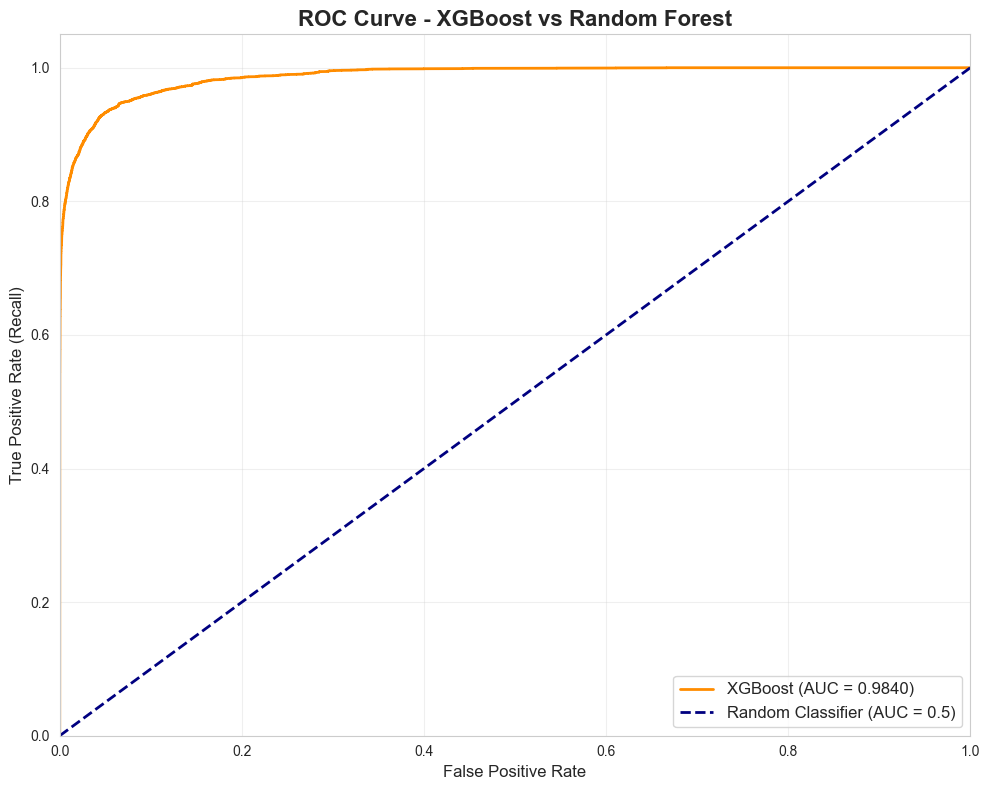

In [8]:
# ============================================
# STEP 5: ROC CURVE
# ============================================

print("ROC CURVE")

# Calculate ROC curve
fpr_roc, tpr_roc, _ = roc_curve(y_test_encoded, tuned_pred_proba)

print(f"\nROC AUC Score: {baseline_roc_auc:.4f}")
print(f"   Random Forest: 0.9795")
print(f"   XGBoost: {baseline_roc_auc:.4f}")
print(f"   Improvement: {baseline_roc_auc-0.9795:+.4f}")

# Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2,
         label=f'XGBoost (AUC = {baseline_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - XGBoost vs Random Forest', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# ============================================
# STEP 6: FEATURE IMPORTANCE
# ============================================

print("FEATURE IMPORTANCE")

# Get feature importances
feature_names = X_train.columns.tolist()
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': tuned_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize
plt.figure(figsize=(12, 10))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 20 Feature Importances - XGBoost', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


FEATURE IMPORTANCE


NameError: name 'tuned_model' is not defined

In [ ]:
# ============================================
# STEP 7: SAVE MODEL
# ============================================

print("SAVING MODEL")

# Save model
model_dir = '../../../models/url-detection'
os.makedirs(model_dir, exist_ok=True)

# Save the XGBoost model
model_path = os.path.join(model_dir, 'xgboost.pkl')
print(f"\nSaving model to: {model_path}")

with open(model_path, 'wb') as f:
    pickle.dump(tuned_model, f)

print("Model saved successfully!")


# Model size
model_size = os.path.getsize(model_path) / (1024 * 1024)
print(f"\nModel file size: {model_size:.2f} MB")
